In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl

# Load Data

In [2]:
data_file_names = ['SafeLearning','Plain','Benchmark']

In [3]:
data = {}
for name in data_file_names:
    with open('./data/{}_eta_0.1.pkl'.format(name),'rb') as f:
        data[name] = pkl.load(f)

In [4]:

with open('./data/Parameters.pkl','rb') as f:
    data['Parameters'] = pkl.load(f)

# Plotting

## The plotting handler

In [5]:
def plot_with_errorband(ax,trial_data,indices = None,label=''):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)
    
    if indices is None:
        indices = range(len(mu))
    
    ax.plot(indices,np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [6]:
data['Parameters']

{'Q': array([[1, 0],
        [0, 1]]),
 'R': array([[1.]]),
 'D_x': array([[ 1.,  0.],
        [ 0.,  1.],
        [-1., -0.],
        [-0., -1.]]),
 'd_x': array([  4., 100.,   4., 100.]),
 'D_u': array([[ 1.],
        [-1.]]),
 'd_u': array([100., 100.]),
 'A': array([[ 1.        ,  0.1       ],
        [-0.01074648,  0.95017871]]),
 'B': array([[0. ],
        [0.1]]),
 'H': 20,
 'H_benchmark': 200,
 'eta_bar': 0.1,
 'w_max': 0.3}

## x,v,u vs time

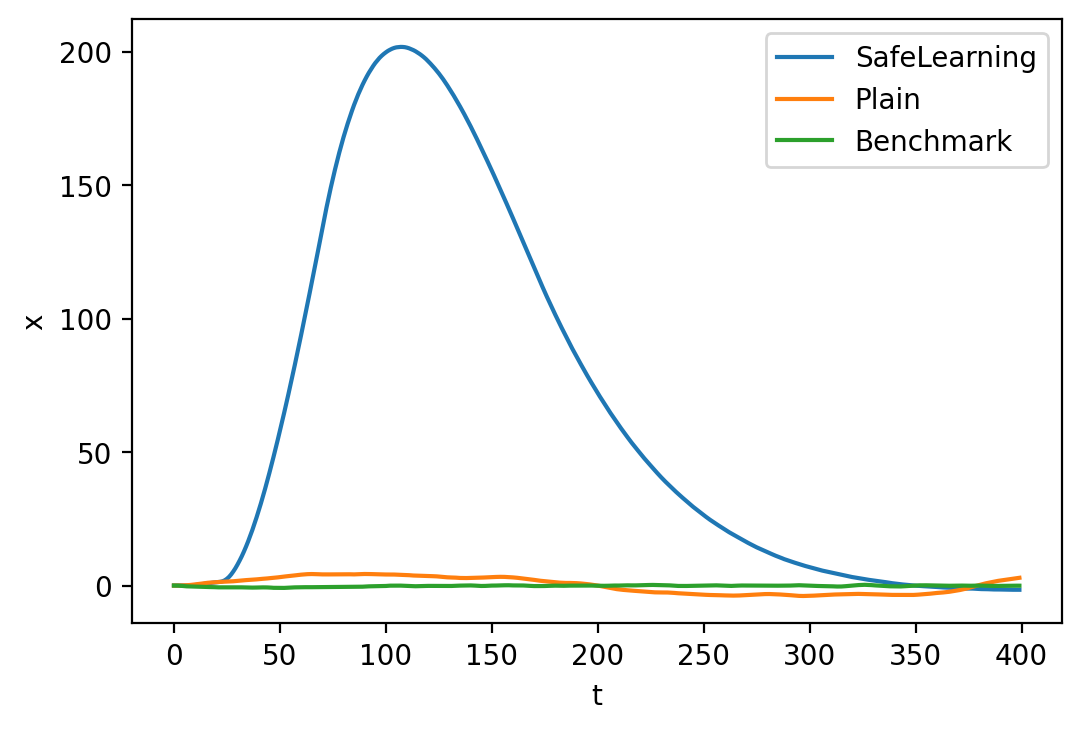

In [7]:
alg_names = ['SafeLearning','Plain','Benchmark']
plt.figure(dpi=200)
ax = plt.gca()

for name in alg_names:
    trial_data = [np.array(d['x'])[:,0].flatten() for d in data[name]]

    plot_with_errorband(ax,trial_data,None,name)

    
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend()


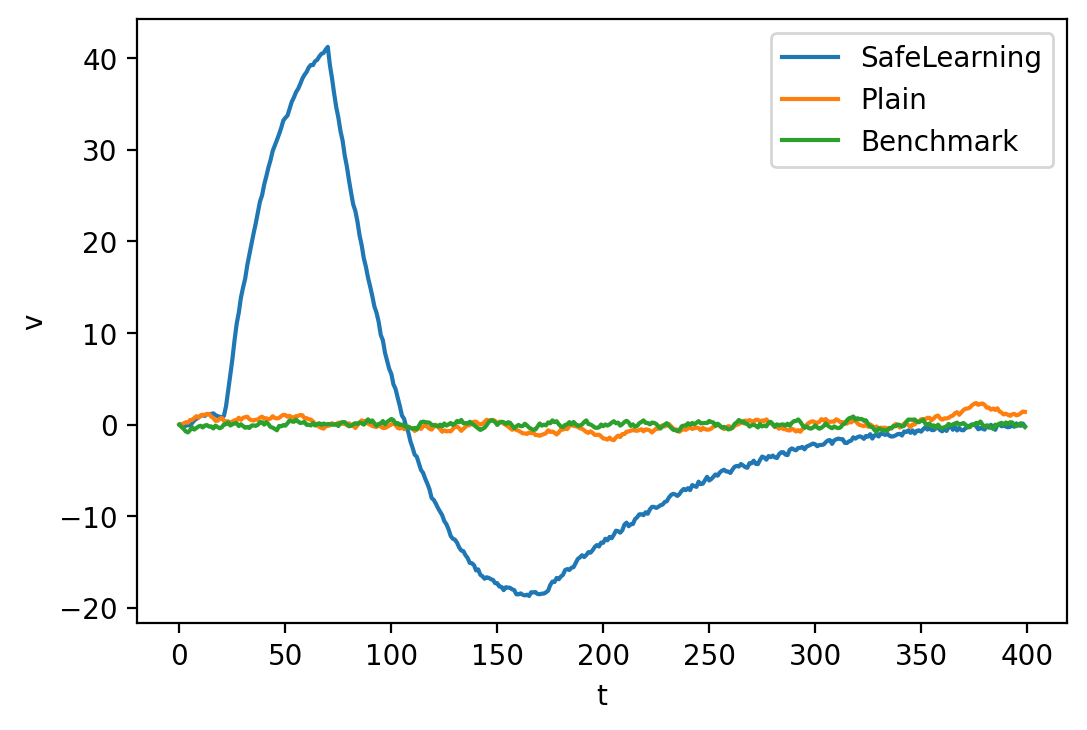

In [8]:
plt.figure(dpi=200)
ax = plt.gca()

for name in alg_names:
    trial_data = [np.array(d['x'])[:,1].flatten() for d in data[name]]

    plot_with_errorband(ax,trial_data,None,name)

ax.set_xlabel('t')
ax.set_ylabel('v')
ax.legend()


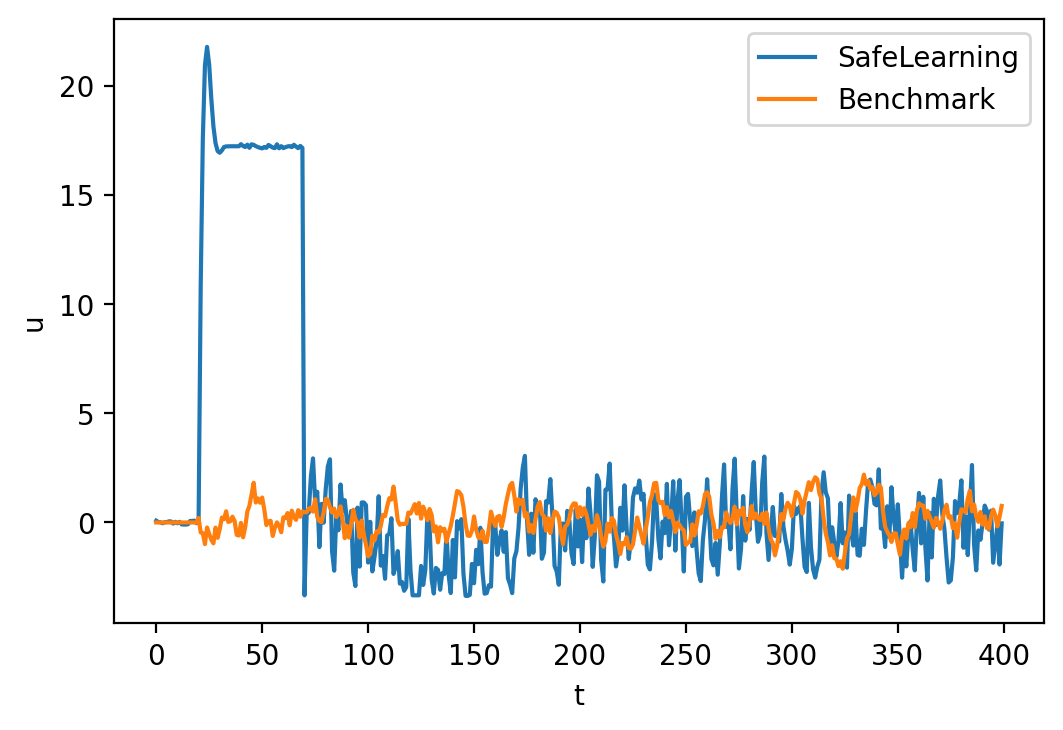

In [9]:
control_alg = ['SafeLearning','Benchmark']
plt.figure(dpi=200)
ax = plt.gca()

for name in control_alg:
    trial_data = [np.array(d['u']).flatten() for d in data[name]]

    plot_with_errorband(ax,trial_data,None,name)

ax.set_xlabel('t')
ax.set_ylabel('u')
ax.legend()


***Figures to plot***

* LQR cost and estimation error vs $\bar{\eta}$. 
* LQR regret vs $t$, compared against DAP with true $A,B$. 
* Estimation error vs t. 
* Also a figure showing unconstraint LQR violates actual constraints, either in x or in u.

In [10]:
def cost(Q,hist):
    n_trial = hist.shape[0]
    timesteps = hist.shape[1]
    Q_cost = [hist[i,j].T.dot(Q).dot(hist[i,j]) for i in range(n_trial) for j in range(timesteps)]

    Q_cost = np.array(Q_cost).reshape(n_trial,timesteps)
    return Q_cost

# LQR Cost and estimation error vs $\bar{\eta}$

## LQR Regret vs $t$

In [11]:
Q = data['Parameters']['Q']
R = data['Parameters']['R']

control_cost = {}
for alg in control_alg:
    
    x_hist = np.array([np.array(d['x']) for d in data[alg]])
    u_hist = np.array([np.array(d['u']) for d in data[alg]])
    control_cost[alg] = cost(Q,x_hist) + cost(R,u_hist[:,:,np.newaxis,np.newaxis])


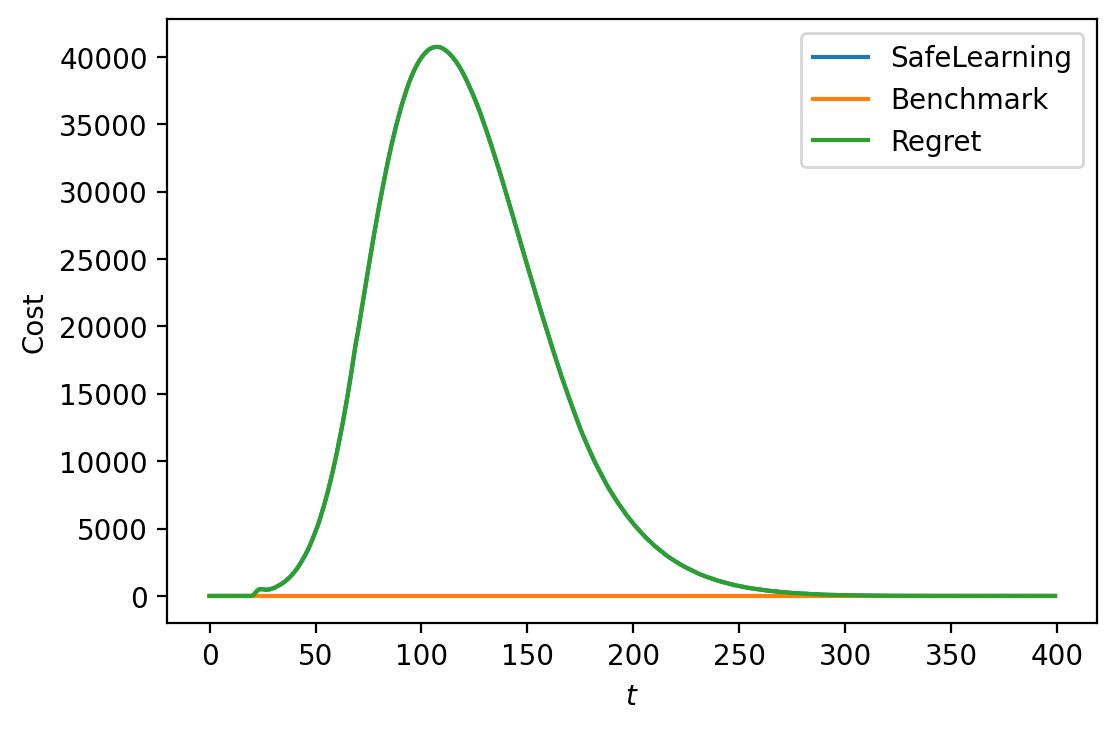

In [12]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in control_cost.items():
    plot_with_errorband(ax,item,None,key)

plot_with_errorband(ax,control_cost['SafeLearning']-control_cost['Benchmark'],None,'Regret')
ax.set_ylabel('Cost')
ax.set_xlabel(r'$t$')
ax.legend()
plt.show()

## Estimation error vs t.

In [13]:
thetas = [d['theta'] for d in data['SafeLearning']]
A = data['Parameters']['A']
B = data['Parameters']['B']

As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])

# As.shape = (# trials, # refits, x_dim, x_dim)
# Bs.shape = (# trials, # refits, x_dim, u_dim)

A_diff = np.linalg.norm(As-A,np.inf,axis=(-1,-2))
B_diff = np.linalg.norm(Bs-B,np.inf,axis=(-1,-2))

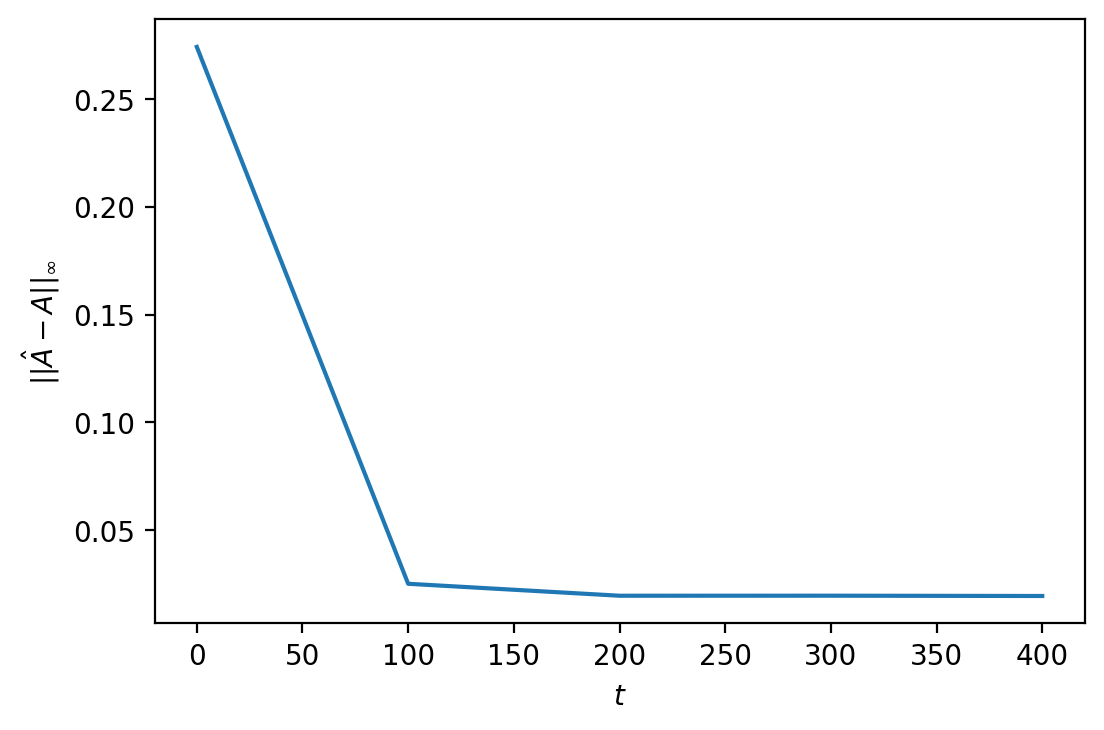

In [14]:
plt.figure(dpi=200)
ax = plt.gca()
plot_with_errorband(ax,A_diff,50*2*np.arange(A_diff.shape[1]))
ax.set_ylabel(r'$||\hat{A}-A||_{\infty}$')
ax.set_xlabel(r'$t$')
plt.show()

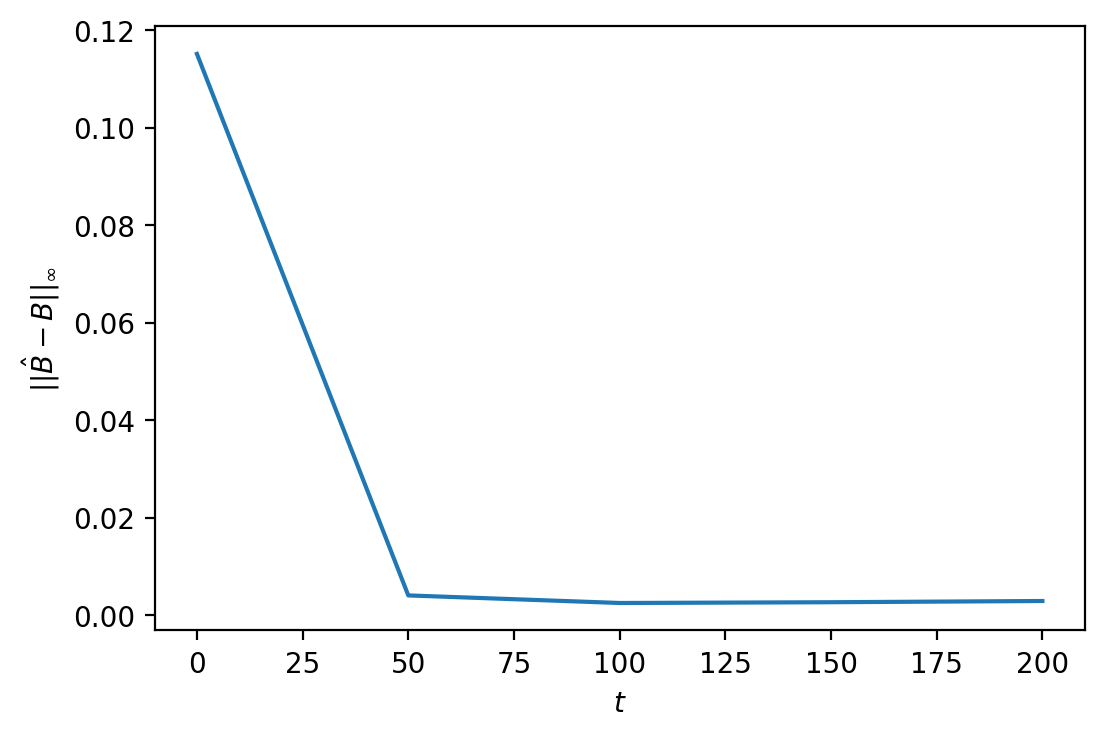

In [15]:
plt.figure(dpi=200)
ax = plt.gca()
plot_with_errorband(ax,B_diff,50*np.arange(A_diff.shape[1]))
ax.set_ylabel(r'$||\hat{B}-B||_{\infty}$')
ax.set_xlabel(r'$t$')
plt.show()